# Data from Horsager et al. 2009

In [1]:
import numpy as np
import scipy.optimize as scpo
import scipy.interpolate as scpi
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
# new_style = {'grid': False}
# plt.rc('axes', **new_style)

import pulse2percept as p2p

2017-06-26 18:53:18,376 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
class HorsagerModel(object):
    def __init__(self, tsample, tau1=0.42/1000, tau2=45.25/1000,
                 tau3=26.25/1000, eps=2.25, beta=3.43):
        self.tsample = tsample
        _, self.gamma1 = p2p.utils.gamma(1, tau1, tsample)
        _, self.gamma2 = p2p.utils.gamma(1, tau2, tsample)
        _, self.gamma3 = p2p.utils.gamma(3, tau3, tsample)
        self.eps = eps
        self.beta = beta
        
    def model_cascade(self, stim):
        # Alan had negative == cathodic, positive == anodic, when it comes
        # to pulse trains. However, the software seems have to implemented
        # the oppposite: I can replicate the results using what we now call
        # anodic-first stimuli - not with cathodic-first.
        # Ergo: Invert the stimulus here:
        stim.data = -stim.data
        
        # R1 convolved the entire stimulus (with both pos + neg parts)
        r1 = self.tsample * p2p.utils.conv(stim.data, self.gamma1, mode='full',
                                           method='sparse')[:stim.data.size]
        
        # However, charge accumulation was done on the anodic phase, it
        # seems. Although the amplitude might be the same as for the cathodic
        # phase, the timing is slightly different!
        ca = self.tsample * np.cumsum(np.maximum(0, stim.data))
        ca = self.tsample * p2p.utils.conv(ca, self.gamma2, mode='full',
                                           method='fft')[:stim.data.size]
        r2 =  r1 - self.eps * ca
        
        # Then half-rectify and pass through the power-nonlinearity
        r3 = np.maximum(0.0, r2) ** self.beta
        
        # Then convolve with slow gamma
        r4 = self.tsample * p2p.utils.conv(r3, self.gamma3, mode='full',
                                           method='fft')#[:stim.data.size]
        
        return r4
    
    def reached_threshold(self, stim, theta):
        return self.model_cascade(stim).max() >= theta

In [3]:
tsample = 0.01 / 1000
model_thresh = HorsagerModel(tsample, tau1=0.42 / 1000, tau2=45.25 / 1000,
                             tau3=26.25 / 1000, eps=2.25, beta=3.43)
model_supra = HorsagerModel(tsample, tau1=0.42 / 1000, tau2=45.91 / 1000,
                            tau3=26.45 / 1000, eps=8.73, beta=0.83)

In [4]:
import pandas as pd
def open_excel(filename, idx_sheet=0):
    xl = pd.ExcelFile(filename)
    df = xl.parse(xl.sheet_names[idx_sheet])
    assert 'Subject' in df.columns
    assert 'Electrode' in df.columns
    assert 'type' in df.columns
    assert 'data' in df.columns
    return df

In [5]:
def plot_panel(model, data, mlabel='model', dlabel='data', xlabel=None, ylabel=None,
               title=None, is_semilogx=False):

    if is_semilogx:
        plt.semilogx(model[:, 0], model[:, 1], '-',
                     linewidth=3, markersize=12, label=mlabel)
        plt.semilogx(data[:, 0], data[:, 1], 's',
                     linewidth=3, markersize=12, label=dlabel)
    else:
        raise NotImplementedError
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.legend()

In [6]:
def get_stim(condition, tsample, amp=0, freq=0, pdur=0):
    if condition == 'single-pulse':
        stim = p2p.stimuli.PulseTrain(tsample, amp=amp, freq=freq, dur=0.5,
                                    pulseorder='gapfirst',
                                    pulsetype='cathodicfirst',
                                    pulse_dur=pdur / 1000.0,
                                    interphase_dur=pdur / 1000.0)
        
    elif condition == 'fixed-duration':
        stim = p2p.stimuli.PulseTrain(tsample, amp=amp,
                                      freq=freq, dur=0.2,
                                      pulseorder='gapfirst',
                                      pulsetype='cathodicfirst',
                                      pulse_dur=pdur / 1000.0,
                                      interphase_dur=pdur / 1000.0)
    else:
        raise ValueError("Unknown condition '%s'." % condition)
        
    return stim

In [7]:
def fit_amp(amp, condition, model, pdurs, theta, freqs=1):
    assert isinstance(condition, str)
    assert isinstance(model, HorsagerModel)
    
    # Find the input current `amp` that produces output `theta`
    pdurs = np.array([pdurs]).ravel()
    freqs = np.array([freqs]).ravel()
    
    mse = 0
    for pdur in pdurs:
        for freq in freqs:
            pt = get_stim(condition, tsample=model.tsample, amp=amp, freq=freq, pdur=pdur)
            theta_pred = model.model_cascade(pt).max()
            mse += (theta - theta_pred) ** 2
        
    return np.sqrt(mse)

## Single-pulse data: Figs. 3, S2.1, S3.1

In [8]:
def load_single_pulse(df, subject, electrode, dtype='truth'):
    rows = (df['Subject'] == subject) & (df['Electrode'] == electrode) & (df['type'] == dtype)
    if not np.any(rows):
        print('Could not find subject %s and electrode %s' % (subject, electrode))
        return None, None, None
    elif np.count_nonzero(rows) > 1:
        print('More than one row found:')
        print(df.loc[rows, :])
        return None, None, None

    # Data points: [all pdurs, all amps]
    theta = float(df.loc[rows, 'theta'])
    data = np.array(df.loc[rows, 'data':])
    data = data.reshape((2, -1))
    return theta, data[0, :], data[1, :]

In [9]:
from os import environ
data = open_excel(environ['SECOND_SIGHT_DATA'] + '/horsager2009/single-pulse.xlsx')

In [10]:
def fit_single_pulse(amp, model, pdurs, theta, freqs=1):
    # Find the input current `amp` that produces output `theta`
    pdurs = np.array([pdurs]).flatten()
    freqs = np.array([freqs]).flatten()
    
    mse = 0
    for pdur in pdurs:
        for freq in freqs:
            pt = p2p.stimuli.PulseTrain(model.tsample, amp=amp, freq=freq,
                                        pulseorder='gapfirst',
                                        pulse_dur=pdur / 1000.0,
                                        interphase_dur=pdur / 1000.0)
            theta_pred = model.model_cascade(pt).max()
            mse += (theta - theta_pred) ** 2
        
    return np.sqrt(mse)

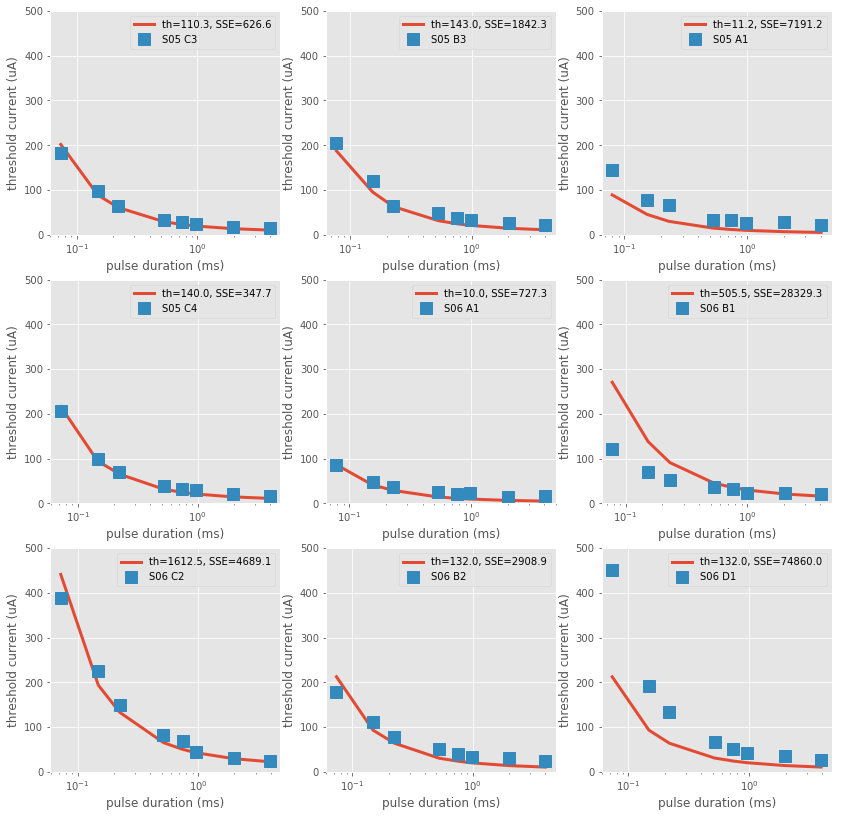

In [11]:
plt.figure(figsize=(14, 14))

subjects =   ['S05', 'S05', 'S05', 'S05', 'S06', 'S06', 'S06', 'S06', 'S06']
electrodes = ['C3',  'B3',  'A1',  'C4',  'A1',  'B1',  'C2',  'B2',  'D1']
idx = 1
freq = 0.001
for subject, electrode in zip(subjects, electrodes):
    plt.subplot(np.ceil(len(subjects) / 3.0), 3.0, idx)

    # Load data from file
    theta, pdurs, amps = load_single_pulse(data, subject, electrode, 'truth')
    
    # Fit model to data, plot panel
    pred = []
    truth = []
    for pdur, amp in zip(pdurs, amps):
        # Add data point to ground truth
        truth.append([pdur, amp])
        
        # Find the input current that produces output `theta`
        pred.append([pdur, scpo.fmin(fit_amp, amp, disp=0,
                                     args=('single-pulse', model_thresh,
                                     pdur, theta, freq))])
    pred = np.array(pred)
    truth = np.array(truth)
    sum_squared_err = np.sum((pred[:, 1] - truth[:, 1]) ** 2)

    # Plot ground-truth data and model prediction
    plot_panel(pred, truth, dlabel=subject + ' ' + electrode,
               mlabel='th=%.1f, SSE=%.1f' % (theta, sum_squared_err),
               xlabel='pulse duration (ms)', ylabel='threshold current (uA)',
               is_semilogx=True)
    plt.ylim(0, 500)
    idx += 1

## Fixed-duration data: Figs. 4, S2.3, S2.4

In [12]:
def load_fixed_duration(df, subject, electrode, pdur, dtype='truth'):
    rows = (df['Subject'] == subject) & (df['Electrode'] == electrode) & \
           (df['pdur'] == pdur) & (df['type'] == dtype)
    if not np.any(rows):
        print('Could not find subject %s and electrode %s' % (subject, electrode))
        return None, None, None
    elif np.count_nonzero(rows) > 1:
        print('More than one row found:')
        print(df.loc[rows, :])
        return None, None, None

    # Data points: [all pdurs, all amps]
    theta = float(df.loc[rows, 'theta'])
    data = np.array(df.loc[rows, 'data':])
    data = data.reshape((2, -1))
    return theta, data[0, :], data[1, :]

In [13]:
data = open_excel(environ['SECOND_SIGHT_DATA'] + '/horsager2009/fixed-duration.xlsx')

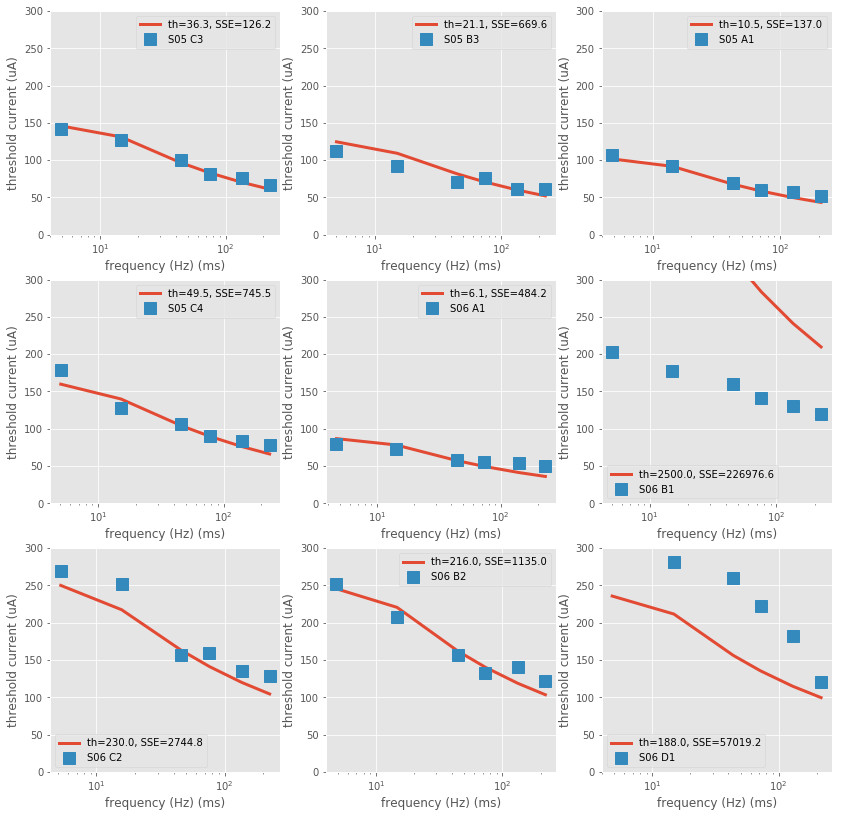

In [14]:
plt.figure(figsize=(14, 14))

subjects =   ['S05', 'S05', 'S05', 'S05', 'S06', 'S06', 'S06', 'S06', 'S06']
electrodes = ['C3',  'B3',  'A1',  'C4',  'A1',  'B1',  'C2',  'B2',  'D1']
pdur = 0.075
idx = 1
for subject, electrode in zip(subjects, electrodes):
    plt.subplot(np.ceil(len(subjects) / 3.0), 3.0, idx)

    # Load data from file
    theta, freqs, amps = load_fixed_duration(data, subject, electrode,
                                             pdur, 'truth')
    
    # Fit model to data, plot panel
    pred = []
    truth = []
    for freq, amp in zip(freqs, amps):
        # Add data point to ground truth
        truth.append([freq, amp])
        
        # Find the input current that produces output `theta`
        pred.append([freq, scpo.fmin(fit_amp, amp, disp=0,
                                     args=('fixed-duration', model_thresh,
                                           pdur, theta, freq))])
    pred = np.array(pred)
    truth = np.array(truth)
    sum_squared_err = np.sum((pred[:, 1] - truth[:, 1]) ** 2)

    # Plot ground-truth data and model prediction
    plot_panel(pred, truth, dlabel=subject + ' ' + electrode,
               mlabel='th=%.1f, SSE=%.1f' % (theta, sum_squared_err),
               xlabel='frequency (Hz) (ms)', ylabel='threshold current (uA)',
               is_semilogx=True)
    plt.ylim(0, 300)
    idx += 1

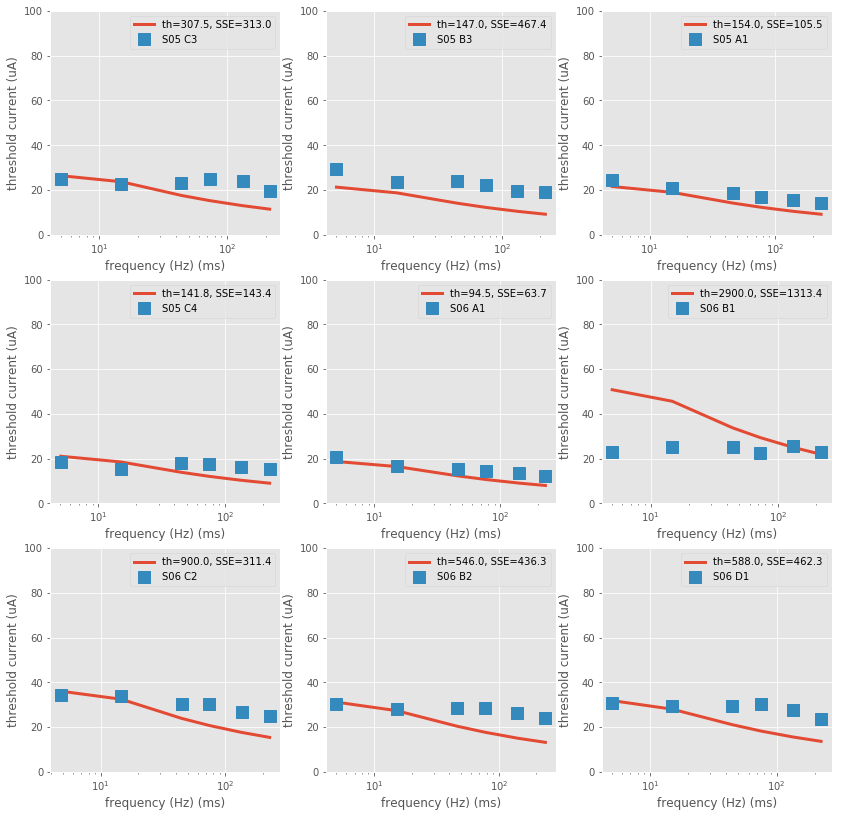

In [15]:
plt.figure(figsize=(14, 14))

subjects =   ['S05', 'S05', 'S05', 'S05', 'S06', 'S06', 'S06', 'S06', 'S06']
electrodes = ['C3',  'B3',  'A1',  'C4',  'A1',  'B1',  'C2',  'B2',  'D1']
pdur = 0.975
idx = 1
for subject, electrode in zip(subjects, electrodes):
    plt.subplot(np.ceil(len(subjects) / 3.0), 3.0, idx)

    # Load data from file
    theta, freqs, amps = load_fixed_duration(data, subject, electrode, pdur, 'truth')
    
    # Fit model to data, plot panel
    pred = []
    truth = []
    for freq, amp in zip(freqs, amps):
        # Add data point to ground truth
        truth.append([freq, amp])
        
        # Find the input current that produces output `theta`
        pred.append([freq, scpo.fmin(fit_amp, amp, disp=0,
                                     args=('fixed-duration', model_thresh, pdur,
                                           theta, freq))])
    pred = np.array(pred)
    truth = np.array(truth)
    sum_squared_err = np.sum((pred[:, 1] - truth[:, 1]) ** 2)

    # Plot ground-truth data and model prediction
    plot_panel(pred, truth, dlabel=subject + ' ' + electrode,
               mlabel='th=%.1f, SSE=%.1f' % (theta, sum_squared_err),
               xlabel='frequency (Hz) (ms)', ylabel='threshold current (uA)',
               is_semilogx=True)
    plt.ylim(0, 80)
    idx += 1

## Fig. 5

In [16]:
fig5b = dict()
fig5b['S05'] = dict()
# I am unsure about the x axis of these data... ticks are off in the paper
fig5b['S05']['C3'] = np.array([3.07744, 177.21735, 6.83354, 161.49903,
                               10.00000, 152.50483, 19.55864, 151.48269,
                               48.42163, 138.42371, 94.70610, 124.19403,
                               178.63580, 134.86406, 426.50218, 125.19536,
                               761.88560, 133.96969]).reshape((-1, 2))
fig5b['S05']['pred'] = np.array([3.07744, 162.12301, 6.95856, 163.76616,
                                 10.18296, 154.01723, 19.20722, 145.44198,
                                 48.42163, 139.93315, 100.00000, 137.03313,
                                 178.63580, 136.75085, 426.50218, 138.02555,
                                 734.75362, 141.13356]).reshape((-1, 2))

fig5b['S06'] = dict()
fig5b['S06']['A1'] = np.array([3.10786, 83.43185, 7.36733, 88.12425,
                               10.52728, 84.33655, 21.42748, 73.99276,
                               49.64420, 78.38359, 99.68801, 76.04343,
                               195.71153, 73.70929, 460.09425, 71.01930,
                               868.52368, 73.92642, 1254.03951, 79.36671,
                               1953.04253, 71.86369, 2802.38075, 71.76719,
                               3521.62464, 74.16767]).reshape((-1, 2))
fig5b['S06']['pred'] = np.array([3.11434, 85.27744, 7.33670, 84.43305,
                                 20.00395, 73.08806, 50.28605, 69.76478,
                                 101.22259, 69.57780, 194.83017, 69.71049,
                                 459.13680, 69.17370, 826.74262, 70.24729,
                                 1299.24542, 70.74186, 1827.72959, 73.11218,
                                 2567.61293, 74.25211, 3224.36285, 76.03739]).reshape((-1, 2))

fig5c = dict()
fig5c['S05'] = dict()
fig5c['S05']['C3'] = np.array([3.05386, 197.09596, 7.39072, 191.44571,
                               10.23531, 173.69792, 20.56512, 137.45265,
                               47.50810, 95.83333, 100.00000, 90.86963,
                               191.79103, 74.90530, 443.06215, 80.16098,
                               792.48290, 85.24306, 1176.81195, 77.69886,
                               1788.64953, 81.10795, 2477.07636, 86.79766,
                               3125.71585, 101.79924]).reshape((-1, 2))
fig5c['S05']['pred'] = np.array([3.19927, 161.19003, 7.05480, 157.03914,
                                 10.00000, 151.02588, 19.63041, 133.51484,
                                 48.62602, 105.22412, 100.00000, 93.21338,
                                 191.79103, 87.40530, 443.06215, 83.28598,
                                 792.48290, 91.49306, 1149.75700, 97.99558,
                                 1788.64953, 107.67045, 2364.48941, 117.23485,
                                 2983.64724, 128.33018]).reshape((-1, 2))

fig5c['S06'] = dict()
fig5c['S06']['A1'] = np.array([3.52346, 76.36364, 8.04368, 74.84848,
                               11.33824, 73.93939, 23.08518, 72.72727,
                               53.92848, 61.21212, 109.03747, 56.96970,
                               201.34433, 43.33333, 482.99140, 53.33333,
                               881.35630, 54.54545, 1263.32518, 50.90909,
                               2043.16307, 49.69697, 2834.15920, 41.81818,
                               3469.78872, 49.69697]).reshape((-1, 2))
fig5c['S06']['pred'] = np.array([3.55805, 80.60606, 8.49951, 78.78788,
                                 11.10336, 74.84848, 22.79706, 67.27273,
                                 51.68129, 52.72727, 109.26595, 47.87879,
                                 206.46597, 44.24242, 471.66795, 43.03030,
                                 861.89537, 44.84848, 1369.82998, 46.06061,
                                 2010.63544, 52.72727, 2687.78137, 58.78788,
                                 3582.96383, 63.63636]).reshape((-1, 2))

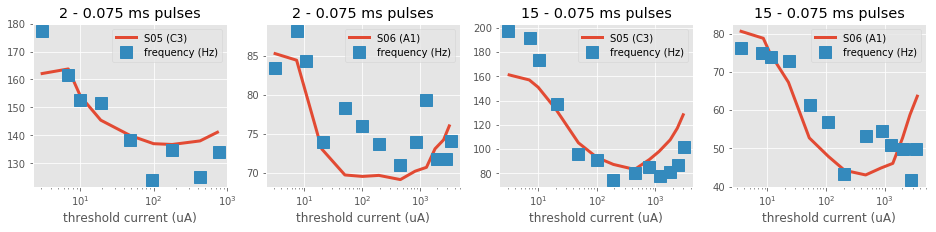

In [17]:
plt.figure(figsize=(16, 3))
plt.subplot(141)
plot_panel(fig5b['S05']['pred'], fig5b['S05']['C3'], 'S05 (C3)',
           'frequency (Hz)', 'threshold current (uA)',
           title='2 - 0.075 ms pulses', is_semilogx=True)

plt.subplot(142)
plot_panel(fig5b['S06']['pred'], fig5b['S06']['A1'], 'S06 (A1)',
           'frequency (Hz)', 'threshold current (uA)',
           title='2 - 0.075 ms pulses', is_semilogx=True)

plt.subplot(143)
plot_panel(fig5c['S05']['pred'], fig5c['S05']['C3'], 'S05 (C3)',
           'frequency (Hz)', 'threshold current (uA)',
           title='15 - 0.075 ms pulses', is_semilogx=True)

plt.subplot(144)
plot_panel(fig5c['S06']['pred'], fig5c['S06']['A1'], 'S06 (A1)',
           'frequency (Hz)', 'threshold current (uA)',
           title='15 - 0.075 ms pulses', is_semilogx=True)

## Fig. 6

In [18]:
fig6b = dict()
fig6b['S05'] = dict()
fig6b['S05']['C4'] = np.array([4.84697, 290.70946, 14.65605, 216.76520,
                               44.03960, 101.54139, 131.23300, 64.61149]).reshape((-1, 2))
fig6b['S05']['pred'] = np.array([4.84472, 295.05912, 14.69349, 192.84206,
                                 44.09071, 90.66723, 126.92173, 77.78716]).reshape((-1, 2))

fig6b['S06'] = dict()
fig6b['S06']['B2'] = np.array([5.13364, 544.65786, 15.72936, 436.73469,
                               48.15207, 220.80832, 146.50276, 148.85954]).reshape((-1, 2))
fig6b['S06']['pred'] = np.array([5.28710, 512.76511, 15.76398, 356.74270,
                                 47.96193, 184.79392, 146.88970, 172.86915]).reshape((-1, 2))

fig6c = dict()
fig6c['S05'] = dict()
fig6c['S05']['C4'] = np.array([4.92707, 55.51020, 14.81826, 46.12245,
                               44.12699, 33.87755, 131.34764, 23.26531]).reshape((-1, 2))
fig6c['S05']['pred'] = np.array([5.08009, 60.81633, 14.83763, 41.22449,
                                 43.79208, 22.44898, 131.43344, 20.81633]).reshape((-1, 2))

fig6c['S06'] = dict()
fig6c['S06']['B2'] = np.array([4.89547, 90.84746, 15.00000, 64.40678, 
                               44.05925, 48.13559, 129.41450, 34.57627]).reshape((-1, 2))
fig6c['S06']['pred'] = np.array([5.21580, 95.59322, 15.00000, 65.76271,
                                 44.05925, 31.86441, 125.37757, 30.50847]).reshape((-1, 2))

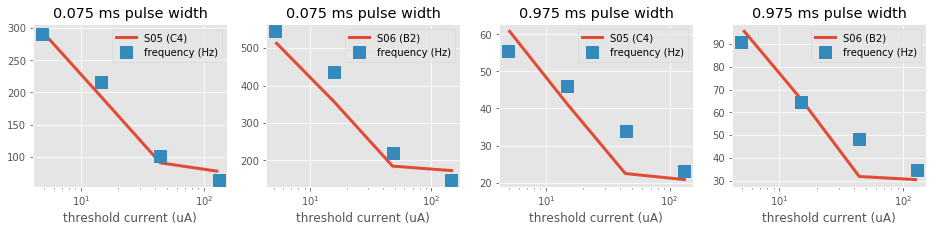

In [19]:
plt.figure(figsize=(16, 3))
plt.subplot(141)
plot_panel(fig6b['S05']['pred'], fig6b['S05']['C4'], 'S05 (C4)',
           'frequency (Hz)', 'threshold current (uA)',
           title='0.075 ms pulse width', is_semilogx=True)

plt.subplot(142)
plot_panel(fig6b['S06']['pred'], fig6b['S06']['B2'], 'S06 (B2)',
           'frequency (Hz)', 'threshold current (uA)',
           title='0.075 ms pulse width', is_semilogx=True)

plt.subplot(143)
plot_panel(fig6c['S05']['pred'], fig6c['S05']['C4'], 'S05 (C4)',
           'frequency (Hz)', 'threshold current (uA)',
           title='0.975 ms pulse width', is_semilogx=True)

plt.subplot(144)
plot_panel(fig6c['S06']['pred'], fig6c['S06']['B2'], 'S06 (B2)',
           'frequency (Hz)', 'threshold current (uA)',
           title='0.975 ms pulse width', is_semilogx=True)

## Fig. 7

In [20]:
fig7b = dict()
fig7b['S05'] = dict()
fig7b['S05']['A1'] = np.array([0.07500, 102.85714, 0.21566, 105.32407,
                               0.77922, 101.17725, 2.73622, 85.91270,
                               9.07500, 75.07937, 31.86677, 76.48148]).reshape((-1, 2))
fig7b['S05']['pred'] = np.array([0.07500, 122.85714, 0.21566, 105.32407,
                                 0.77922, 83.39947, 2.73622, 79.24603,
                                 8.57140, 76.17725, 28.42811, 87.56614]).reshape((-1, 2))

fig7b['S06'] = dict()
fig7b['S06']['A2'] = np.array([0.05390, 76.89713, 0.18178, 69.77904,
                               0.73072, 56.47897, 2.74012, 45.49774,
                               9.88461, 49.90734, 34.45921, 62.01473]).reshape((-1, 2))
fig7b['S06']['pred'] = np.array([0.05622, 80.73652, 0.18116, 70.54882,
                                 0.71671, 54.17439, 2.78418, 48.57211,
                                 10.02069, 46.82823, 32.34757, 56.25564]).reshape((-1, 2))

fig7c = dict()
fig7c['S05'] = dict()
fig7c['S05']['A1'] = np.array([0.07100, 63.55556, 0.21996, 62.66667,
                               0.61105, 66.66667, 1.95776, 59.55556,
                               5.91455, 58.22222, 16.90637, 60.00000]).reshape((-1, 2))
fig7c['S05']['pred'] = np.array([0.07096, 84.00000, 0.22210, 75.11111,
                                 0.61560, 60.88889, 1.92674, 52.00000,
                                 5.97560, 50.22222, 16.70504, 49.33333]).reshape((-1, 2))
fig7c['S06'] = dict()
fig7c['S06']['A2'] = np.array([0.06976, 105.71429, 0.21176, 111.42857,
                               0.57051, 70.00000, 1.79585, 57.14286,
                               5.22288, 52.14286]).reshape((-1, 2))
fig7c['S06']['pred'] = np.array([0.07147, 106.42857, 0.20869, 95.00000,
                                 0.56699, 80.00000, 1.78477, 67.14286,
                                 5.05703, 64.28571, 15.40613, 64.28571]).reshape((-1, 2))

fig7d = dict()
fig7d['S05'] = dict()
fig7d['S05']['A1'] = np.array([0.06887, 60.00000, 0.21330, 57.33333,
                               0.43121, 56.66667, 1.15031, 50.66667,
                               2.81768, 46.00000, 7.05067, 45.66667]).reshape((-1, 2))
fig7d['S05']['pred'] = np.array([0.07500, 71.33333, 0.20879, 64.33333,
                                 0.43121, 54.00000, 1.15031, 44.00000,
                                 2.81768, 42.66667, 6.90187, 41.33333]).reshape((-1, 2))
fig7d['S06'] = dict()
fig7d['S06']['A2'] = np.array([0.07063, 114.67387, 0.22384, 113.63604,
                               0.44308, 113.49189, 1.21084, 85.08108,
                               3.08311, 74.19820, 7.97296, 66.96216]).reshape((-1, 2))
fig7d['S06']['pred'] = np.array([0.07166, 132.25946, 0.21430, 114.21261,
                                 0.43542, 97.72252, 1.18762, 83.85586,
                                 3.05931, 79.04144, 8.51573, 79.12793]).reshape((-1, 2))

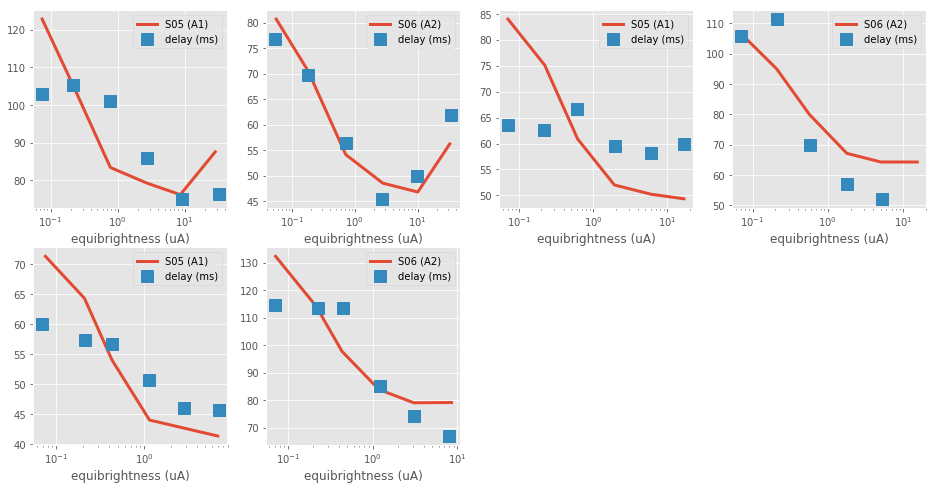

In [21]:
plt.figure(figsize=(16, 8))
plt.subplot(241)
plot_panel(fig7b['S05']['pred'], fig7b['S05']['A1'], 'S05 (A1)',
           'delay (ms)', 'equibrightness (uA)',
           is_semilogx=True)

plt.subplot(242)
plot_panel(fig7b['S06']['pred'], fig7b['S06']['A2'], 'S06 (A2)',
           'delay (ms)', 'equibrightness (uA)',
           is_semilogx=True)

plt.subplot(243)
plot_panel(fig7c['S05']['pred'], fig7c['S05']['A1'], 'S05 (A1)',
           'delay (ms)', 'equibrightness (uA)',
           is_semilogx=True)

plt.subplot(244)
plot_panel(fig7c['S06']['pred'], fig7c['S06']['A2'], 'S06 (A2)',
           'delay (ms)', 'equibrightness (uA)',
           is_semilogx=True)

plt.subplot(245)
plot_panel(fig7d['S05']['pred'], fig7d['S05']['A1'], 'S05 (A1)',
           'delay (ms)', 'equibrightness (uA)',
           is_semilogx=True)

plt.subplot(246)
plot_panel(fig7d['S06']['pred'], fig7d['S06']['A2'], 'S06 (A2)',
           'delay (ms)', 'equibrightness (uA)',
           is_semilogx=True)
